<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>

# Stationarity Data and ARIMA Model
*This lab was developed by: <br> Jose Luis Rodriguez, Director of Margolis Market Information Lab, R.C. Evans Innovation Fellow at Gies College of Business
<br> Meiou Wen, MSF Teaching Assistant, Gies College of Business*

On this lab we will begin with stationarity, the first and necessary step in analyzing time series data. We will learn how to identify if a time series is stationary or not and know how to make nonstationary data become stationary:

* Develop an understanding of stationarity, identifying two forms of it and their importance in time series analysis
* Understand stationarity testing procedure: how to conduct a stationarity test, how to read the ADF test result, how to make a nonstationary series become stationary, and how to determine the order of integration
* Understand the various components of ARIMA parameters, and understand the procedure of modelling ARIMA forecasting
* Identify opportunities for utilizing ARIMA forecasting model in reality

### Packages and Configurations

* tidyverse: https://www.tidyverse.org/
* lubridate: https://lubridate.tidyverse.org/
* tseries: https://cran.r-project.org/web/packages/tseries
* forecast: https://cran.r-project.org/web/packages/forecast/
* xts: https://cran.r-project.org/web/packages/xts

In [1]:
# SUPPRESS PACKAGE WARNINGS
quietly <- suppressPackageStartupMessages

# DISABLE SCIENTIFIC NOTATION
options(scipen = 9999)

# CHANGE CHARTS DIMENSIONS
options(repr.plot.width=12, repr.plot.height=7)

# LOAD PACKAGES SUPRESS WARNINGS
quietly(library(xts))
quietly(library(tidyverse))
quietly(library(lubridate))
quietly(library(forecast))
quietly(library(urca))

### Data Import and Exploration

#### SPY US - SPDR S&P 500 ETF Trust

SPDR S&P 500 ETF Trust is an exchange-traded fund incorporated in the USA. The ETF tracks the S&P 500 Index. The Trust consists of a portfolio representing all 500 stocks in the S&P 500 Index. It holds predominantly large-cap U.S. stocks. This ETF is structured as a Unit Investment Trust and pays dividends on a quarterly basis. The holdings are weighted by market capitalization. 

In [2]:
# READ THE .CSV FILE AS DATA FRAME
spy_df = read_csv("data/SPY.csv")

Parsed with column specification:
cols(
  date = col_character(),
  open = col_double(),
  high = col_double(),
  low = col_double(),
  close = col_double(),
  volume = col_character()
)



In [3]:
head(spy_df)

date,open,high,low,close,volume
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
6/26/20,306.16,306.39,299.4200,300.05,127.961M
6/25/20,303.47,307.64,301.2800,307.35,89.468M
6/24/20,309.84,310.51,302.1000,304.09,132.813M
6/23/20,313.49,314.50,311.6101,312.05,68.471M
6/22/20,307.99,311.05,306.7500,310.62,74.649M
6/19/20,314.17,314.38,306.5300,308.64,135.55M


In [4]:
# CREATE AN EMPTY COLUMN volume
volume = c()
# CREATE A LOOP FUNCTION TO FILL IN volume
for(entry in spy_df$volume){
    if(str_detect(string = entry, "M")){
        v = gsub("M","", entry)
        v = as.numeric(v) * 1000000
        volume = c(volume, v)
    }
    else if(str_detect(string = entry, "k")){
        v = gsub("k","", entry)
        v = as.numeric(v) * 1000
        volume = c(volume, v)
    }
    else{
        v = as.numeric(entry)
        volume = c(volume, v)
    }
}

In [5]:
# APPEND volume TO spy_df
spy_df$volume = volume

In [6]:
# CHECK THE FIRST FEW ROWS OF spy_df
head(spy_df)

date,open,high,low,close,volume
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6/26/20,306.16,306.39,299.4200,300.05,127961000
6/25/20,303.47,307.64,301.2800,307.35,89468000
6/24/20,309.84,310.51,302.1000,304.09,132813000
6/23/20,313.49,314.50,311.6101,312.05,68471000
6/22/20,307.99,311.05,306.7500,310.62,74649000
6/19/20,314.17,314.38,306.5300,308.64,135550000


In [7]:
# CREATE A NEW OBJECT, spy_xts, CONVERT date IN spy_df TO POSIXct TIME FORMAT AND ORDER BY TIME
spy_xts = xts(select(spy_df,-c("date")), 
             order.by = as.POSIXct(strptime(spy_df$date,"%m/%d/%y")))

In [8]:
# ASSIGN THE FIRST ITEM IN spy_xts TO spy_start
spy_start = index(spy_xts[1])
spy_start = c(year(spy_start),month(spy_start))

# ASSIGN THE LAST ITEM IN spy_xts TO spy_end
spy_end = index(spy_xts[length(spy_xts[,'close'])])
spy_end = c(year(spy_end), month(spy_end))

# CREATE A TIME-SERIES OBJECT AND ASSIGN TO spy_ts
spy_ts = ts(spy_xts, start = spy_start, end = spy_end, frequency = 365)

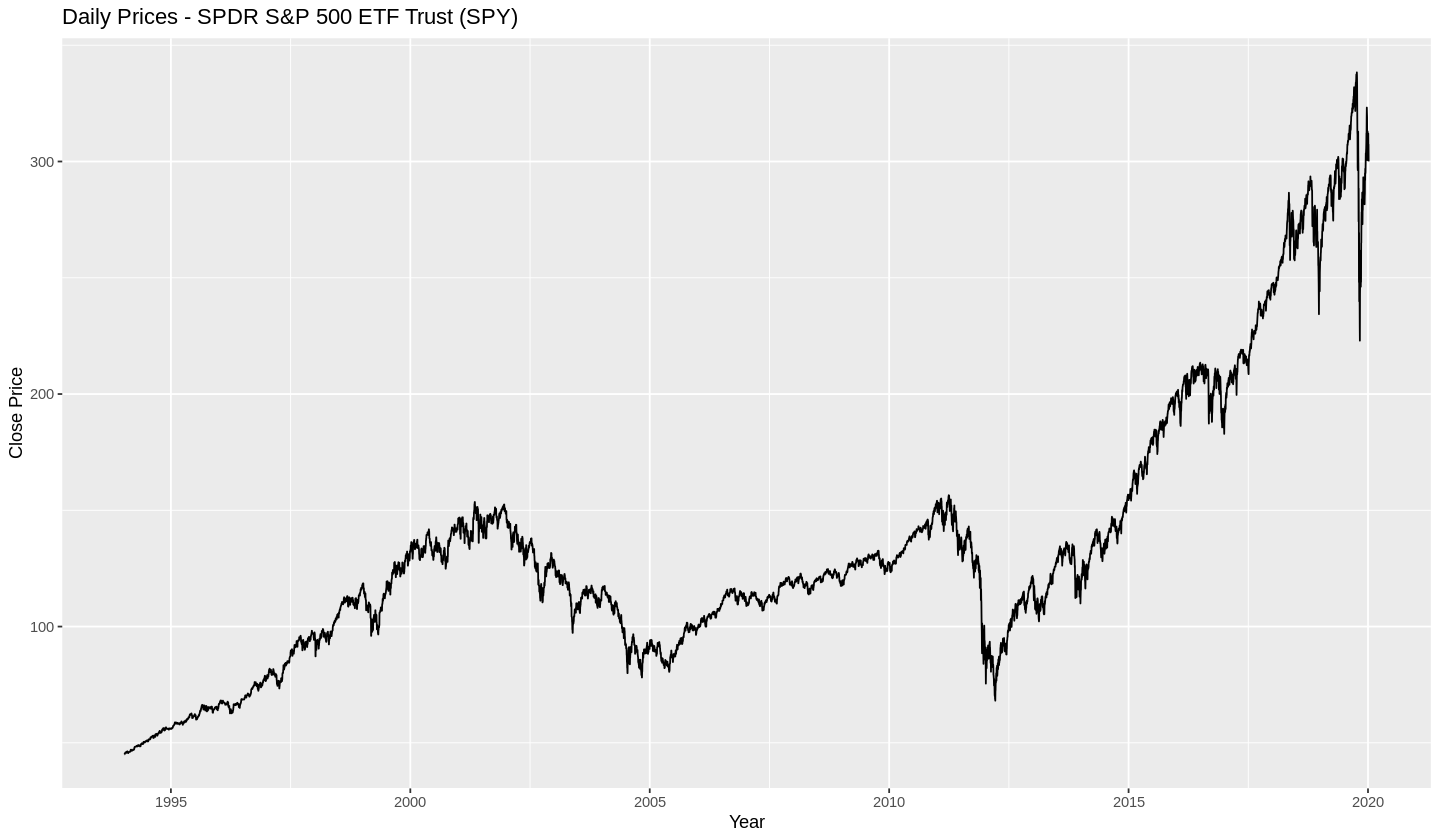

In [9]:
# PLOT THE DAILY CLOSING PRICE
autoplot(spy_ts[,"close"], xlab = "Year", ylab = "Close Price",
         main = "Daily Prices - SPDR S&P 500 ETF Trust (SPY)")

#### US Census Bureau - Total Construction Spending (TTLCON/TCS)

The Value of Construction Put in Place Survey (VIP) provides monthly estimates of the total dollar value of construction work done in the U.S. The survey covers construction work done each month on new structures or improvements to existing structures for private and public sectors. Data estimates include the cost of labor and materials, cost of architectural and engineering work, overhead costs, interest and taxes paid during construction, and contractor's profits.  

* https://fred.stlouisfed.org/series/TTLCON
* https://www.census.gov/construction/c30/c30index.html

In [10]:
# READ THE .CSV FILE AS DATA FRAME
tcs_df = read_csv("data/TTLCON.csv")

Parsed with column specification:
cols(
  DATE = col_date(format = ""),
  TTLCON = col_double()
)



In [11]:
# CREATE A NEW OBJECT, tcs_xts, CONVERT date IN tcs_df TO POSIXct TIME FORMAT AND ORDER BY TIME
tcs_xts = xts(select(tcs_df,-c("DATE")), 
             order.by = as.POSIXct(strptime(tcs_df$DATE,"%Y-%d-%m")))

In [12]:
# ASSIGN THE FIRST ITEM IN tcs_xts TO tcs_start
tcs_start = index(tcs_xts[1])
tcs_start = c(year(tcs_start),month(tcs_start))

# ASSIGN THE LAST ITEM IN tcs_xts TO tcs_end
tcs_end = index(tcs_xts[length(tcs_xts)])
tcs_end = c(year(tcs_end), month(tcs_end))

# CREATE A TIME-SERIES OBJECT AND ASSIGN TO tcs_ts
tcs_ts = ts(tcs_xts[,"TTLCON"], start = tcs_start, end = tcs_end, frequency = 12)

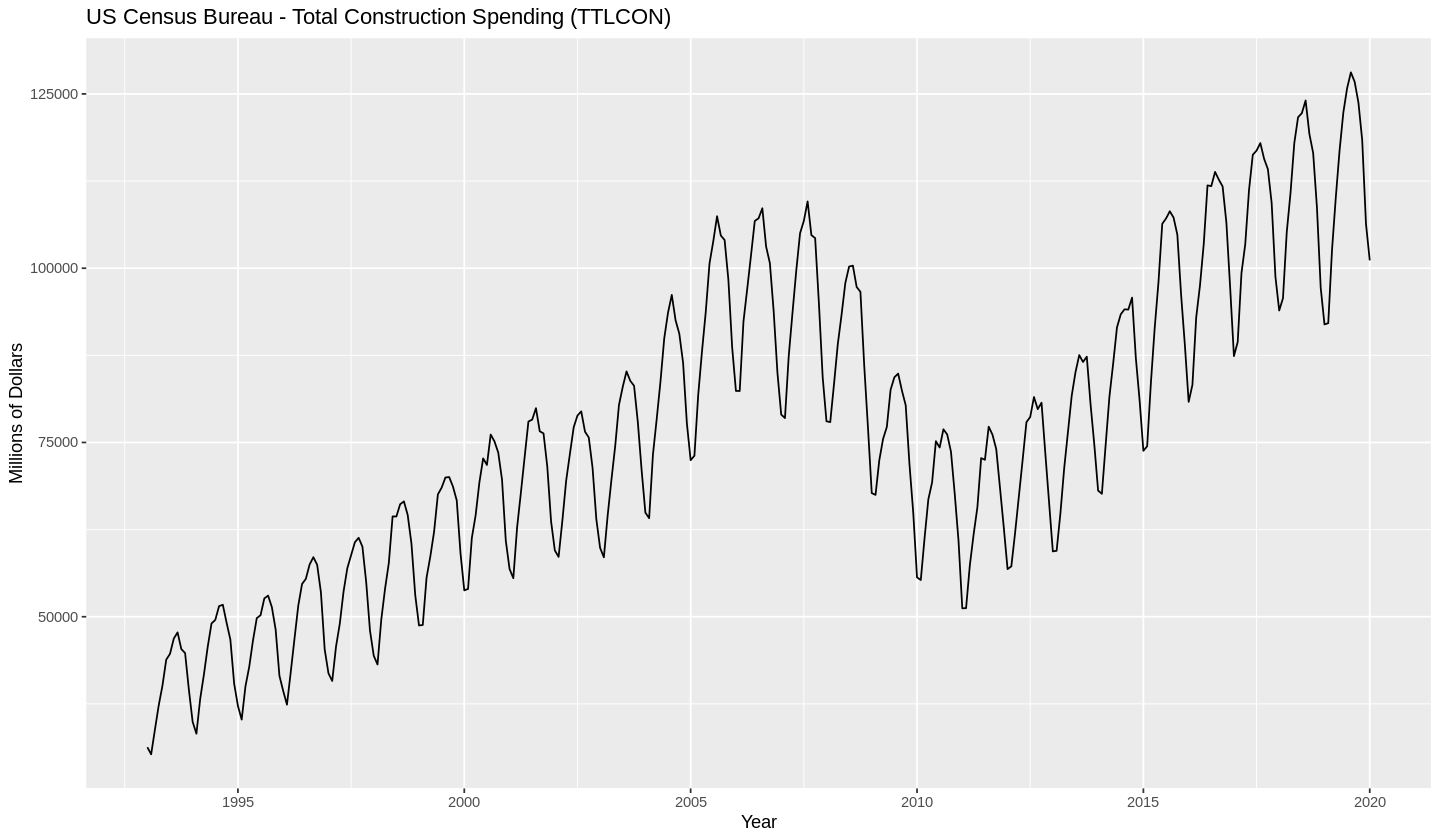

In [13]:
# PLOT THE YEARLY TTLCON
autoplot(tcs_ts, xlab = "Year", ylab = "Millions of Dollars",
         main = "US Census Bureau - Total Construction Spending (TTLCON)")

## Stationary and Non-Stationarity Time Series Data

### Testing for Stationary on SPDR S&P 500 ETF (SPY)

In [14]:
# SPY Closing Price
spy_close = spy_ts[,"close"]

# PERFORM A TEST REGRESSION 
spy_adf = ur.df(spy_close, type = "none", selectlags = "AIC")
summary(spy_adf)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.0722  -0.2906   0.0064   0.4096  19.4202 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)    
z.lag.1     0.0001988  0.0001078   1.844              0.0652 .  
z.diff.lag -0.1257218  0.0102034 -12.322 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.528 on 9481 degrees of freedom
Multiple R-squared:  0.01599,	Adjusted R-squared:  0.01579 
F-statistic: 77.05 on 2 and 9481 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: 1.8438 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


In [15]:
# Difference SPY Closing Price
spy_close_diff = diff(spy_close, lag = 1, differences = 1)

# PERFORM A TEST REGRESSION 
spy_adf = ur.df(spy_close_diff, type = "none", selectlags = "AIC")
summary(spy_adf)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.4989  -0.2672   0.0241   0.4329  19.9556 

Coefficients:
           Estimate Std. Error t value             Pr(>|t|)    
z.lag.1    -1.08109    0.01541 -70.170 < 0.0000000000000002 ***
z.diff.lag -0.03925    0.01028  -3.819             0.000135 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.528 on 9480 degrees of freedom
Multiple R-squared:  0.5627,	Adjusted R-squared:  0.5626 
F-statistic:  6099 on 2 and 9480 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -70.1699 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


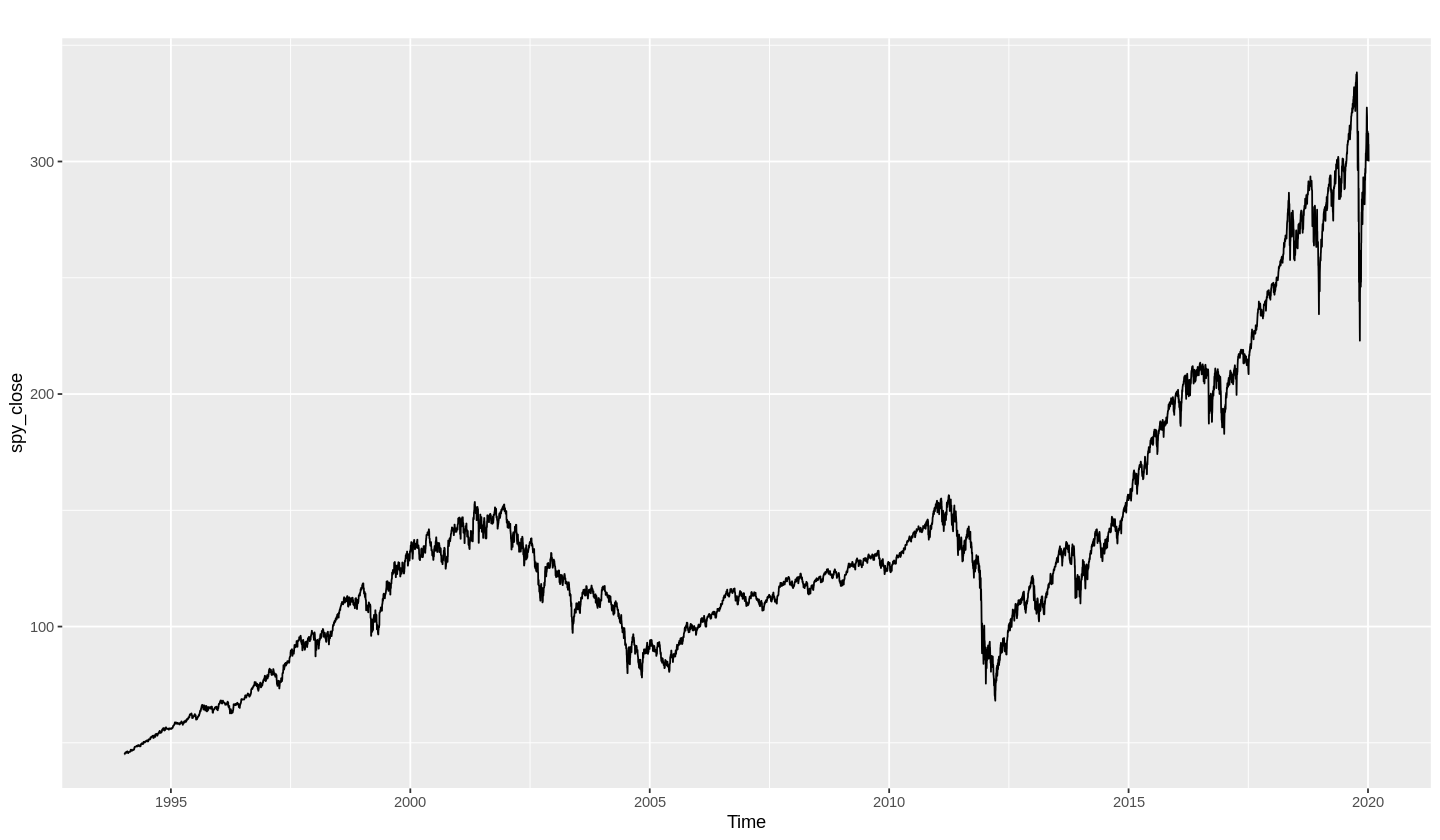

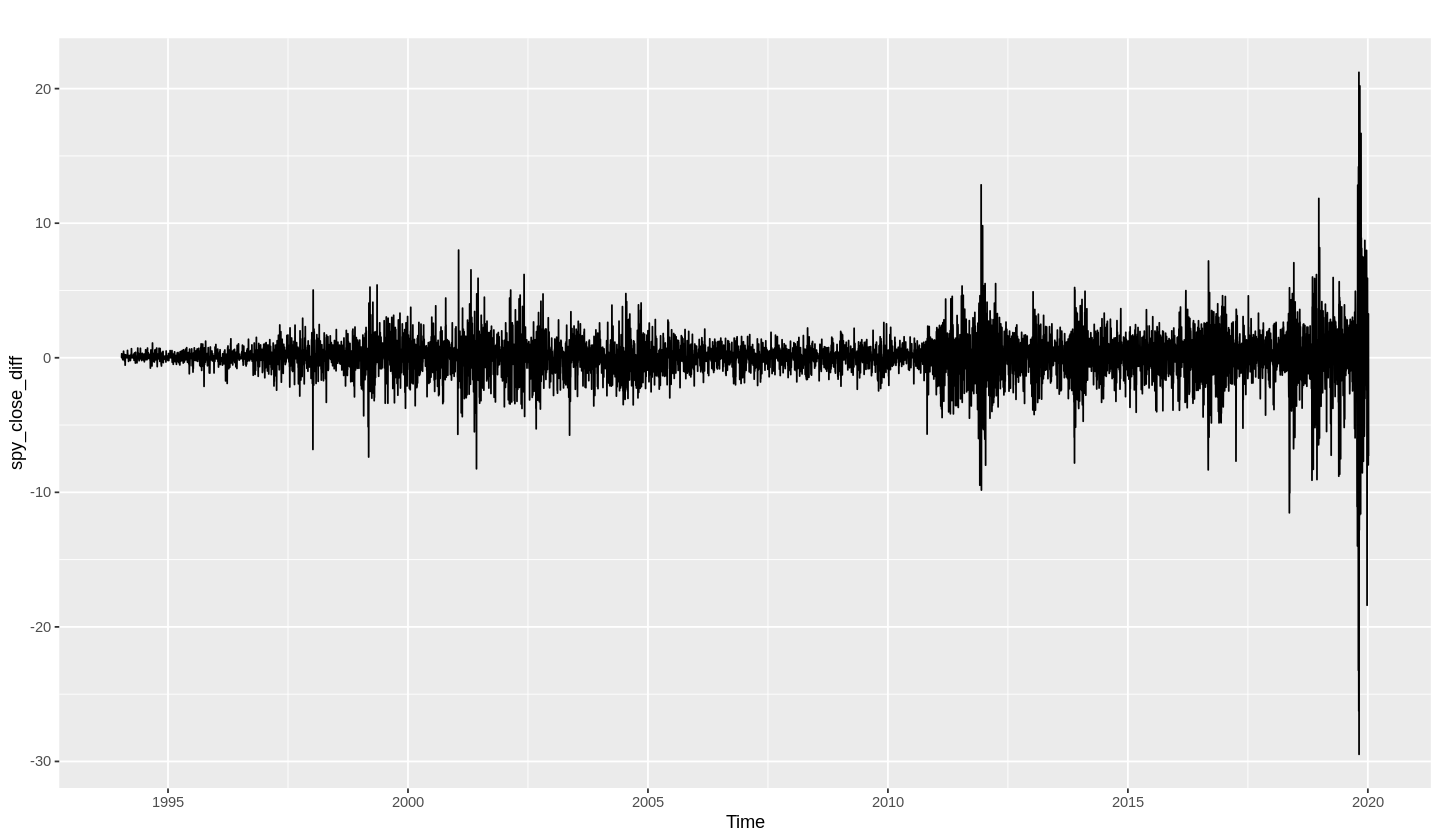

In [16]:
# PLOT SPY Closing Price AND Difference SPY Closing Price
autoplot(spy_close)
autoplot(spy_close_diff)

### Testing for Stationarity on US Total Construction Spending Data

In [17]:
# Total Construction Spending
tscl_spending = tcs_ts[,"TTLCON"]

# PERFORM A TEST REGRESSION 
tscl_spending_adf = ur.df(tscl_spending, type = "none", selectlags = "AIC")
summary(tscl_spending_adf)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-9807.9 -2187.7   356.4  2102.7 10632.2 

Coefficients:
            Estimate Std. Error t value            Pr(>|t|)    
z.lag.1    -0.002579   0.002608  -0.989               0.324    
z.diff.lag  0.661331   0.042181  15.678 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3727 on 321 degrees of freedom
Multiple R-squared:  0.4337,	Adjusted R-squared:  0.4302 
F-statistic: 122.9 on 2 and 321 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -0.9887 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


In [18]:
# Difference Total Construction Spending
tscl_spending_diff = diff(tscl_spending, lag = 1, differences = 1)

# PERFORM A TEST REGRESSION 
tscl_spending_adf = ur.df(tscl_spending_diff, type = "none", selectlags = "AIC")
summary(tscl_spending_adf)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-10607.3  -2469.2    307.1   2440.2   9264.6 

Coefficients:
           Estimate Std. Error t value             Pr(>|t|)    
z.lag.1    -0.41454    0.04548  -9.115 < 0.0000000000000002 ***
z.diff.lag  0.21007    0.05512   3.811             0.000166 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3649 on 320 degrees of freedom
Multiple R-squared:  0.2061,	Adjusted R-squared:  0.2012 
F-statistic: 41.54 on 2 and 320 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -9.1149 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


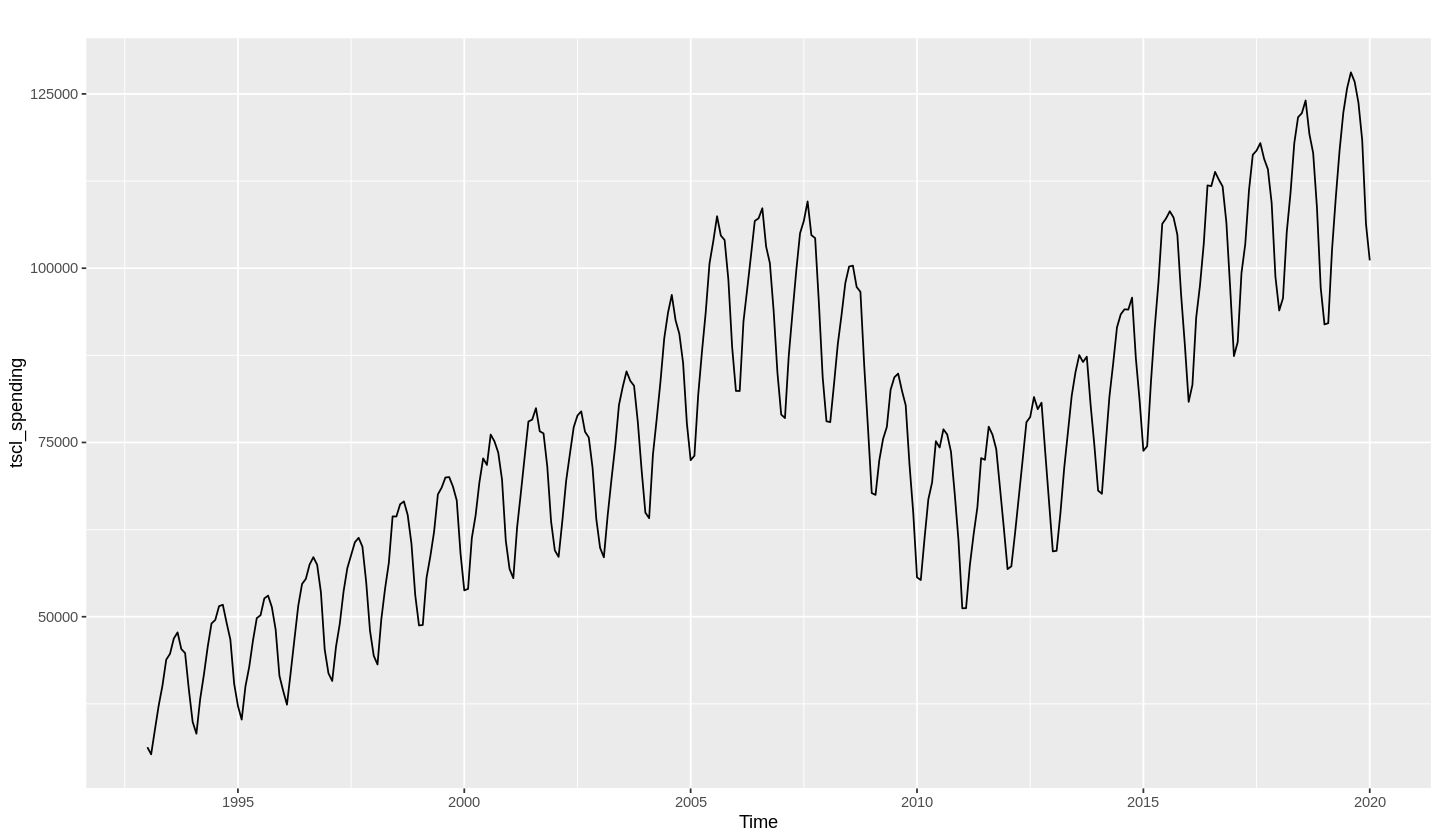

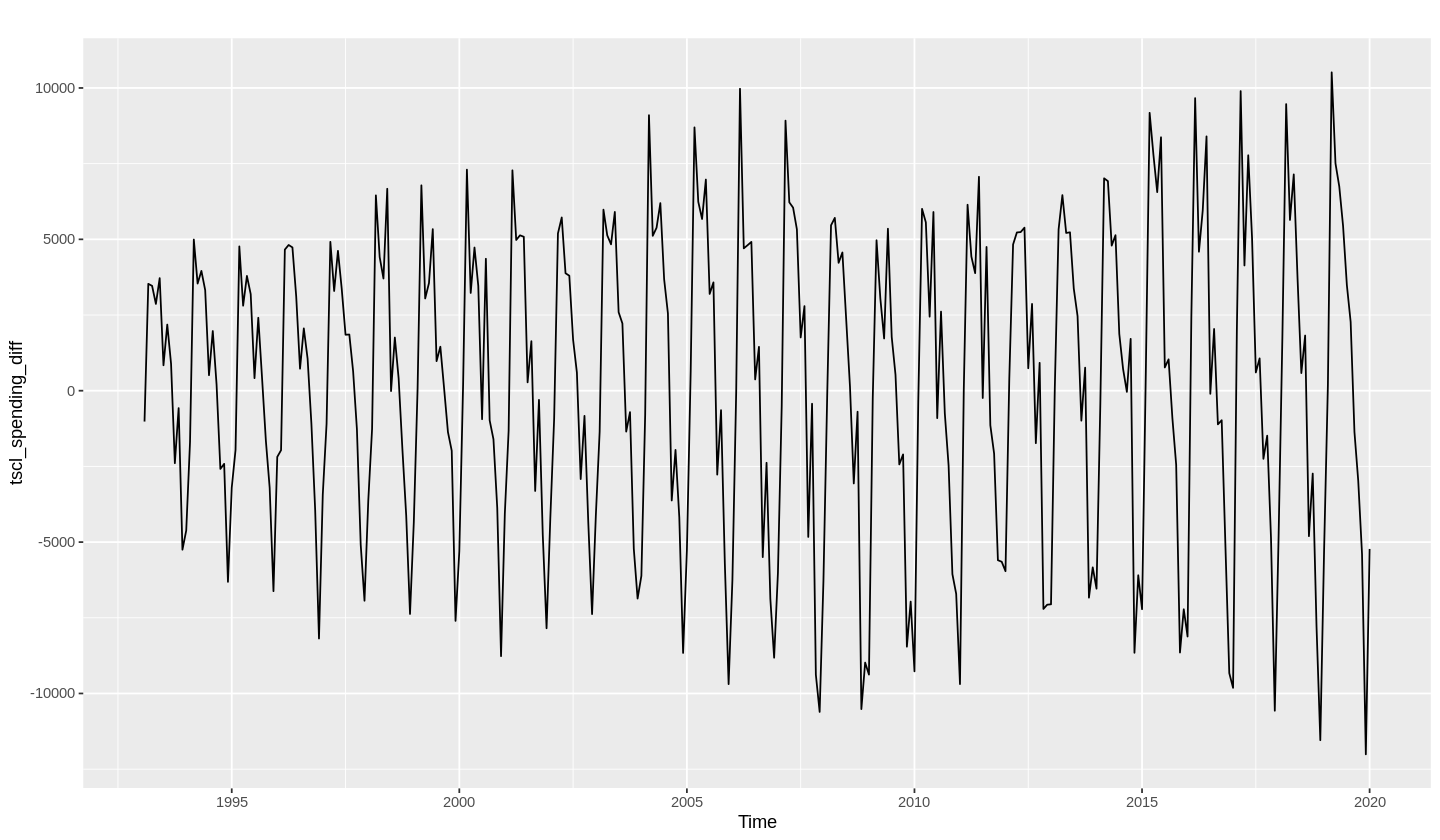

In [19]:
# PLOT Total Construction Spending AND Difference Total Construction Spending
autoplot(tscl_spending)
autoplot(tscl_spending_diff)

## ARIMA

### SPY 4-years Closing Daily Prices to Monthly Prices

In [20]:
# DAILY CLOSING PRICE FOR 10 YEARS
spy_10yrs = spy_xts["2010-01-01/2020-06-26"][,'close']
# ASSIGN THE FIRST MONTH IN spy_10yrs TO spy_start
spy_start = index(spy_10yrs[1])
spy_start = c(year(spy_start),month(spy_start))
# CREATE A TIME-SERIES OBJECT AND ASSIGN TO spy_10yrs_ts
spy_10yrs_ts = ts(spy_10yrs, start = spy_start, frequency = 365)

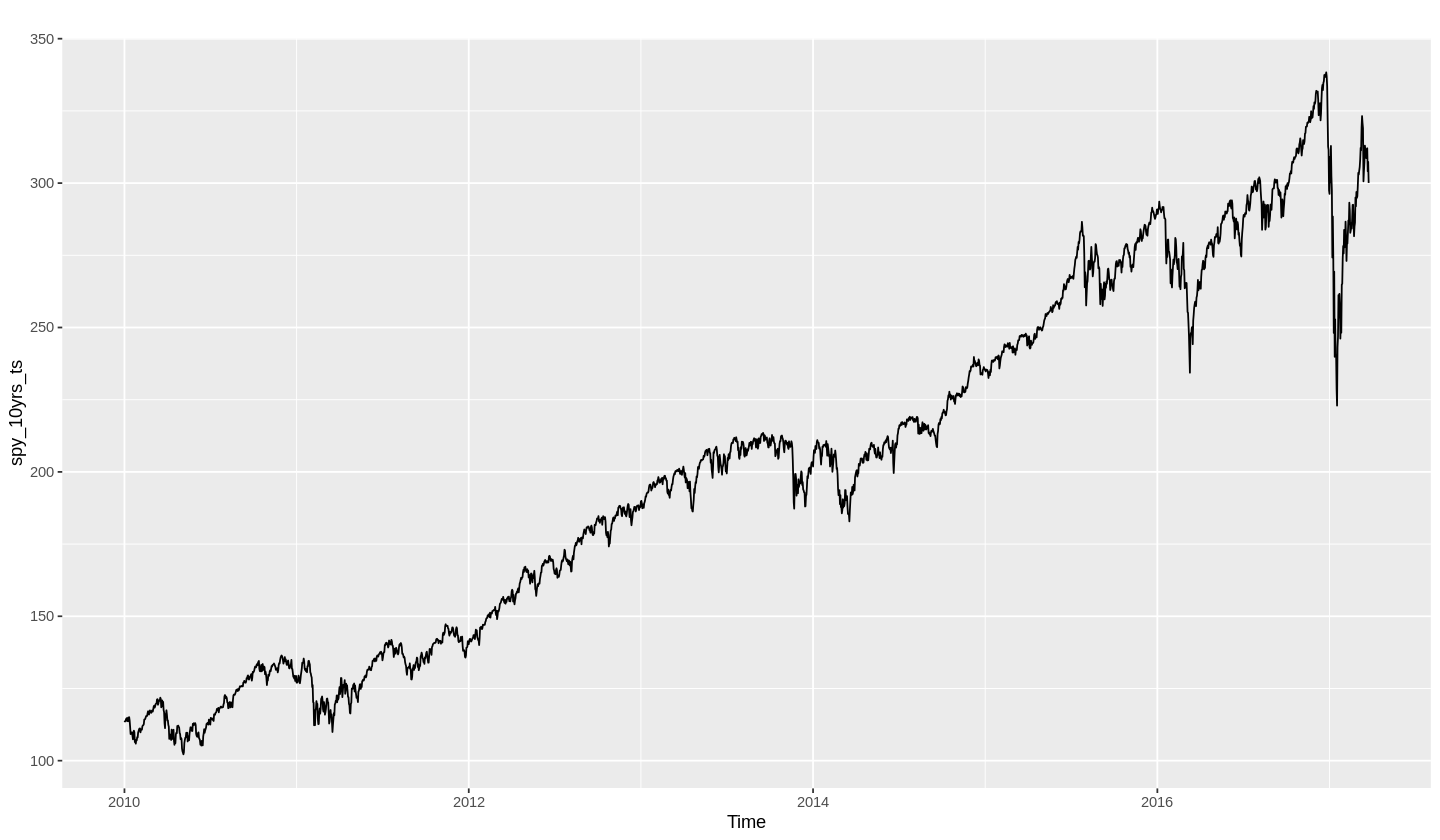

In [21]:
# PLOT spy_10yrs_ts
autoplot(spy_10yrs_ts)

In [22]:
# CLEAN spy_10yrs_ts BY OMITTING THE NA VALUES 
spy_diff_ts = na.omit(diff(spy_10yrs_ts, lag = 1, differences = 1))

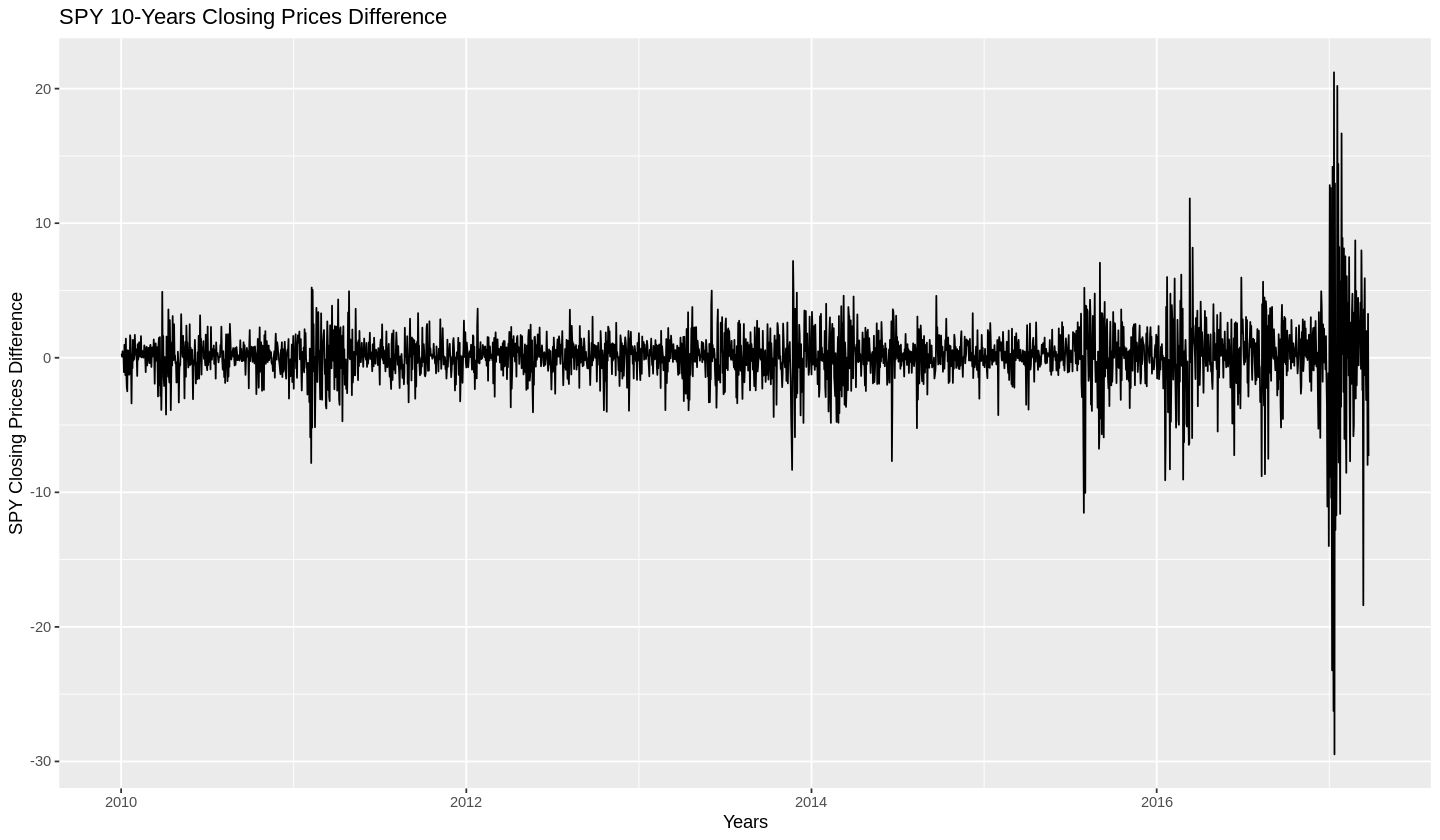

In [23]:
# PLOT SPY CLOSING PRICE DIFFERENCE BY TIME
autoplot(spy_diff_ts,
         xlab = "Years",
         ylab = "SPY Closing Prices Difference",
         main = "SPY 10-Years Closing Prices Difference")

In [24]:
# PERFORM A TEST REGRESSION
spy_adf = ur.df(spy_diff_ts, type = "none", selectlags = "AIC")
summary(spy_adf)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.6795  -0.6716   0.1497   1.0205  20.3722 

Coefficients:
           Estimate Std. Error t value             Pr(>|t|)    
z.lag.1    -1.06151    0.02968  -35.76 < 0.0000000000000002 ***
z.diff.lag -0.09079    0.01944   -4.67           0.00000317 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.338 on 2634 degrees of freedom
Multiple R-squared:  0.5862,	Adjusted R-squared:  0.5859 
F-statistic:  1866 on 2 and 2634 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -35.7629 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


### Autocorrelation and Cross-Correlation Function

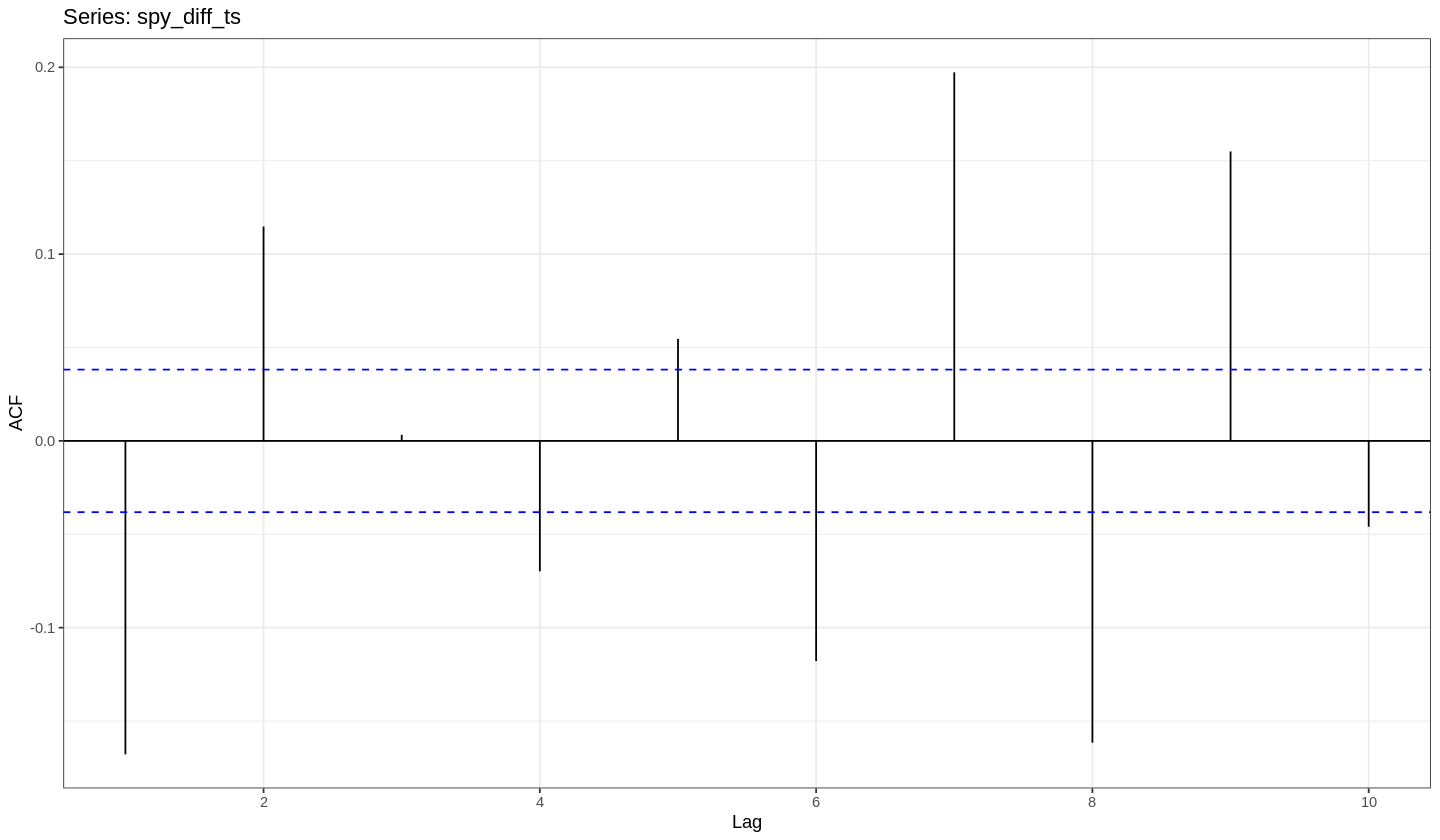

In [25]:
# PLOT spy_diff_ts WITH ESTIMATES OF THE AUTOCORRELATION FUNCTION
ggAcf(x = spy_diff_ts, lag.max = 10) + theme_bw()

### Partial Autocorrelation and Cross-Correlation Function

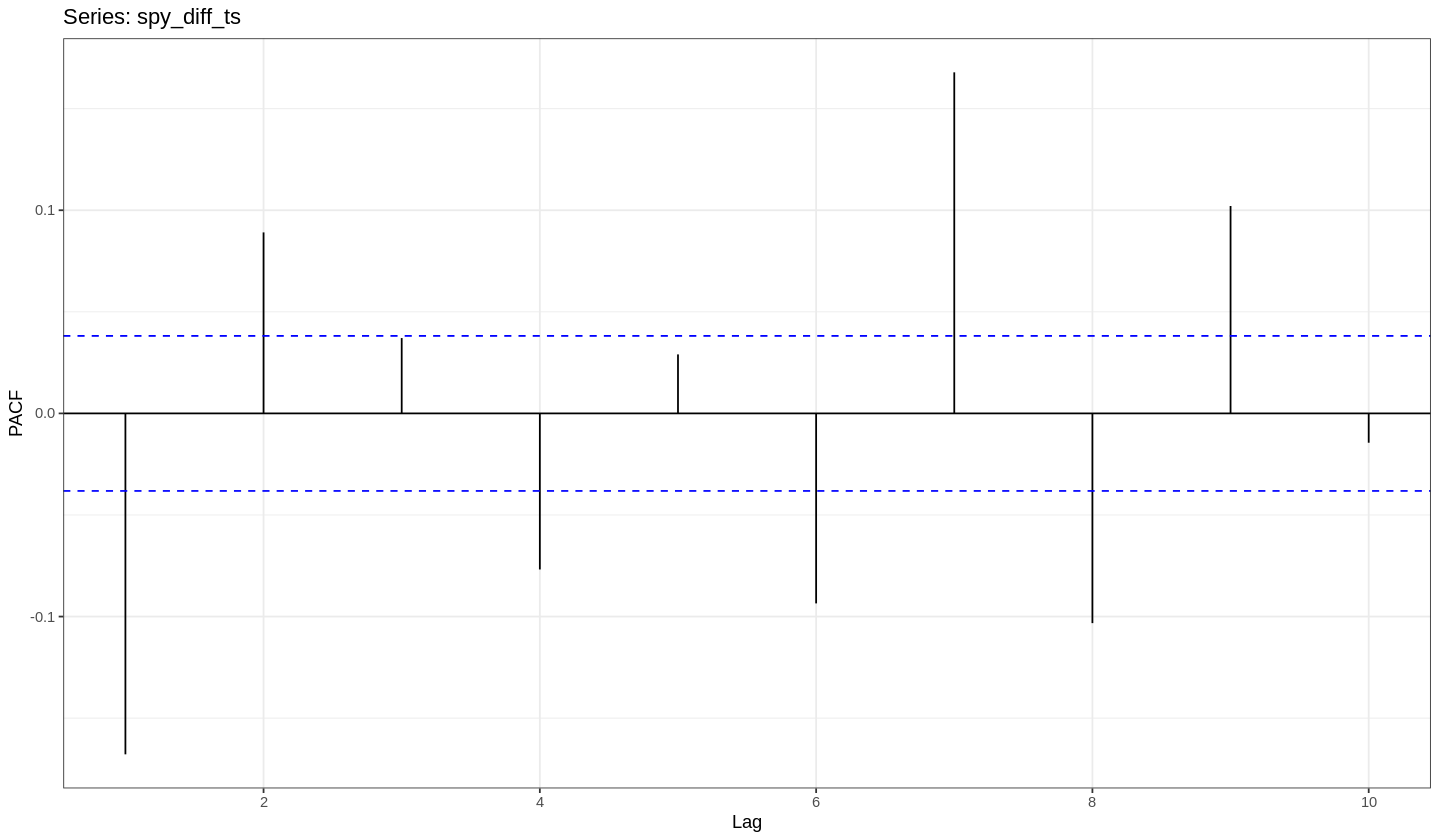

In [26]:
# PLOT spy_diff_ts WITH ESTIMATES OF THE PARTIAL AUTOCORRELATION FUNCTION
ggPacf(x = spy_diff_ts, lag.max = 10) + theme_bw()

## Fitting the ARIMA Model to SPY Monthly Closing Difference Data

In [27]:
# FIT AN ARIMA MODEL TO spy_diff_ts 
spy_model_01 = Arima(spy_diff_ts, order = c(1, 0, 1))
summary(spy_model_01)

Series: spy_diff_ts 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1    mean
      -0.4221  0.2555  0.0711
s.e.   0.0627  0.0652  0.0402

sigma^2 estimated as 5.476:  log likelihood=-5984.57
AIC=11977.13   AICc=11977.15   BIC=12000.64

Training set error measures:
                        ME     RMSE      MAE MPE MAPE      MASE       ACF1
Training set 0.00008205901 2.338838 1.381917 NaN  Inf 0.6825649 0.01109095


In [28]:
# FIT AN ARIMA MODEL TO spy_diff_ts 
spy_model_02 = Arima(spy_diff_ts, order = c(1, 0, 2))
summary(spy_model_02)

Series: spy_diff_ts 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
          ar1      ma1     ma2    mean
      -0.0785  -0.0759  0.1198  0.0708
s.e.   0.1150   0.1134  0.0264  0.0439

sigma^2 estimated as 5.446:  log likelihood=-5976.82
AIC=11963.64   AICc=11963.66   BIC=11993.03

Training set error measures:
                       ME     RMSE     MAE MPE MAPE      MASE          ACF1
Training set 0.0001526155 2.331974 1.38418 NaN  Inf 0.6836827 -0.0005800892


In [29]:
# FIT AN ARIMA MODEL TO spy_diff_ts 
spy_model_03 = Arima(spy_diff_ts, order = c(2, 0, 1))
summary(spy_model_03)

Series: spy_diff_ts 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
          ar1     ar2      ma1    mean
      -0.0025  0.1166  -0.1519  0.0711
s.e.   0.1307  0.0278   0.1307  0.0435

sigma^2 estimated as 5.456:  log likelihood=-5979.18
AIC=11968.37   AICc=11968.39   BIC=11997.76

Training set error measures:
                        ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.0001522998 2.334066 1.382749 NaN  Inf 0.6829761 -0.001386331


In [30]:
# FIT AN ARIMA MODEL TO spy_diff_ts 
spy_model_04 = Arima(spy_diff_ts, order = c(2, 0, 2))
summary(spy_model_04)

Series: spy_diff_ts 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2    mean
      -0.1951  -0.2072  0.0424  0.3077  0.0711
s.e.   0.1495   0.1054  0.1451  0.1009  0.0437

sigma^2 estimated as 5.441:  log likelihood=-5975.02
AIC=11962.04   AICc=11962.07   BIC=11997.3

Training set error measures:
                        ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.0001476656 2.330379 1.384671 NaN  Inf 0.6839256 -0.002215696


## ARIMA Forecasting Plot and Auto ARIMA Function

In [31]:
# DAILY CLOSING PRICE FOR 10 YEARS
spy_10yrs = spy_xts["2010-01-01/2020-06-26"][,'close']
# CONVERT TO A MONTHLY SERIES
spy_10yrs = to.monthly(spy_10yrs)[,'spy_10yrs.Close']

# ASSIGN THE FIRST MONTH IN spy_10yrs TO spy_start
spy_start = index(spy_10yrs[1])
spy_start = c(year(spy_start),month(spy_start))
# ASSIGN THE LAST MONTH IN spy_10yrs TO spy_end
spy_end = index(spy_10yrs[length(spy_10yrs)])
spy_end = c(year(spy_end),month(spy_end))

# CREATE A TIME-SERIES OBJECT AND ASSIGN TO spy_10yrs_ts
spy_10yrs_ts = ts(spy_10yrs, start = spy_start, end = spy_end, frequency = 12)

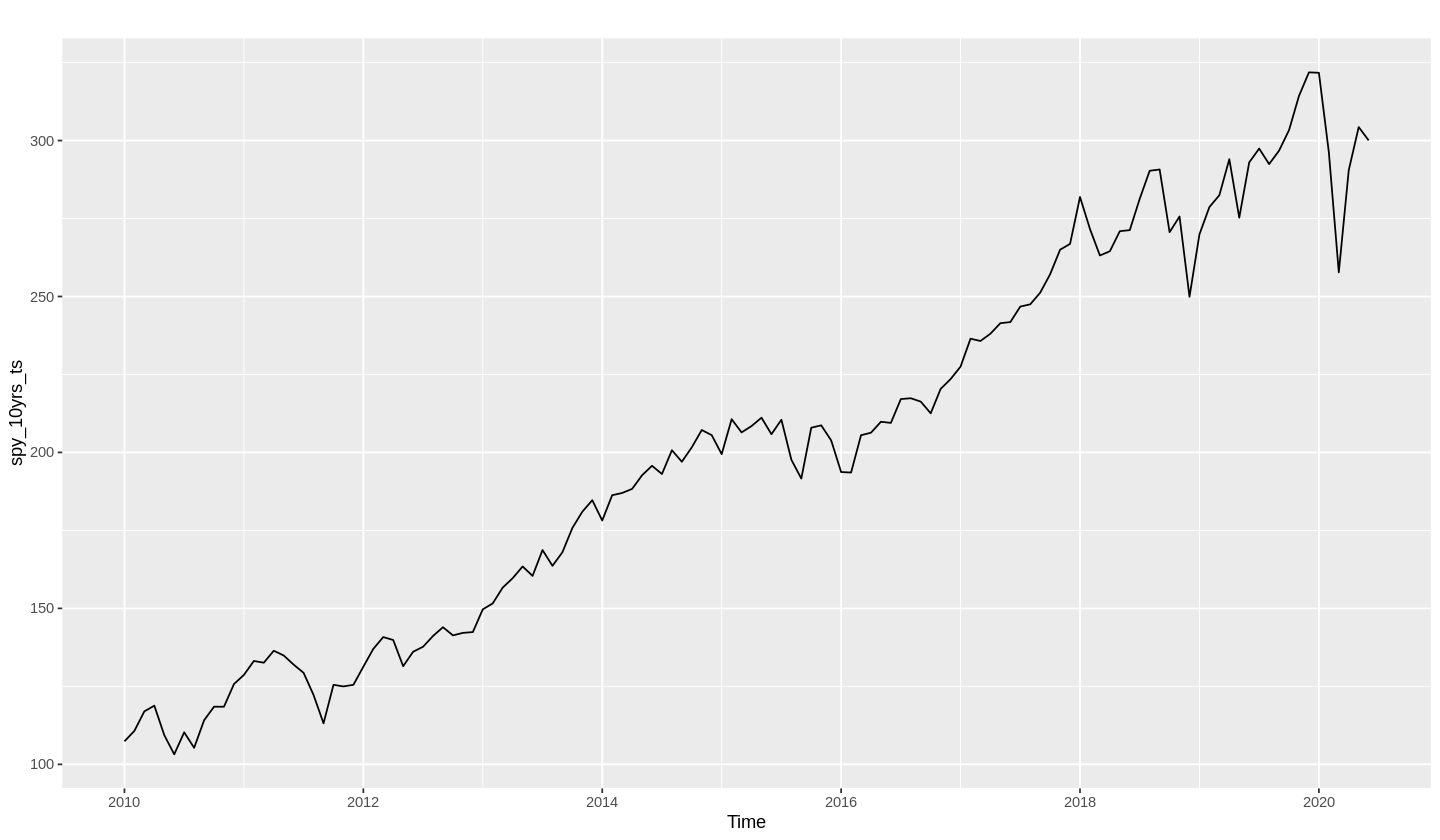

In [32]:
# PLOT spy_10yrs_ts
autoplot(spy_10yrs_ts)

In [33]:
# FIT BEST ARIMA MODEL TO spy_10yrs_ts
spy_model = auto.arima(spy_10yrs_ts)

In [34]:
# PERFORM AUTOMATIC TIME SERIES FORECASTING
spy_predict = forecast(spy_model, h = 7)

In [35]:
# SUMMARY OF THE FORECASTING RESULT
summary(spy_predict)


Forecast method: ARIMA(1,1,1)(0,0,2)[12] with drift

Model Information:
Series: spy_10yrs_ts 
ARIMA(1,1,1)(0,0,2)[12] with drift 

Coefficients:
         ar1      ma1     sma1    sma2   drift
      0.5948  -0.8363  -0.0936  0.1892  1.5400
s.e.  0.2420   0.1935   0.1050  0.1585  0.3373

sigma^2 estimated as 67.86:  log likelihood=-439.02
AIC=890.04   AICc=890.75   BIC=907.01

Error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.03280565 8.039256 5.582667 -0.1511629 2.825995 0.2612597
                   ACF1
Training set 0.02565077

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2020       303.7649 293.2078 314.3220 287.6191 319.9107
Aug 2020       308.0239 294.7735 321.2742 287.7592 328.2885
Sep 2020       309.6716 294.9169 324.4263 287.1062 332.2370
Oct 2020       307.2550 291.4772 323.0328 283.1250 331.3850
Nov 2020       308.7275 292.1605 325.2944 283.3905 334.0644
Dec 2020       304.8715 287.6416 322.1013

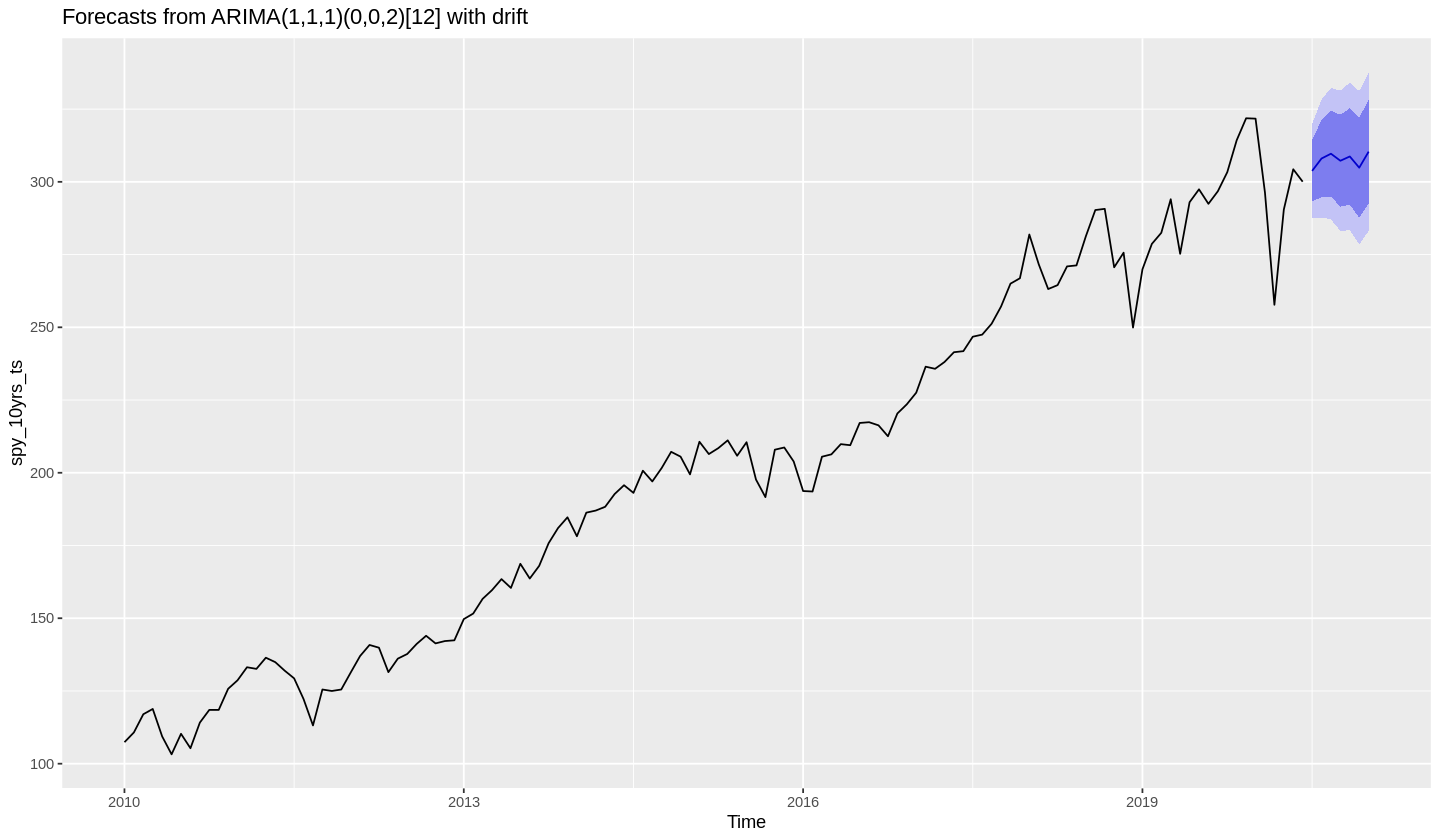

In [36]:
# PLOT THE FORECASTING RESULT
autoplot(spy_predict, includes = 20)

### US Total Construction Spending Data 

### Autocorrelation and Cross-Correlation Function

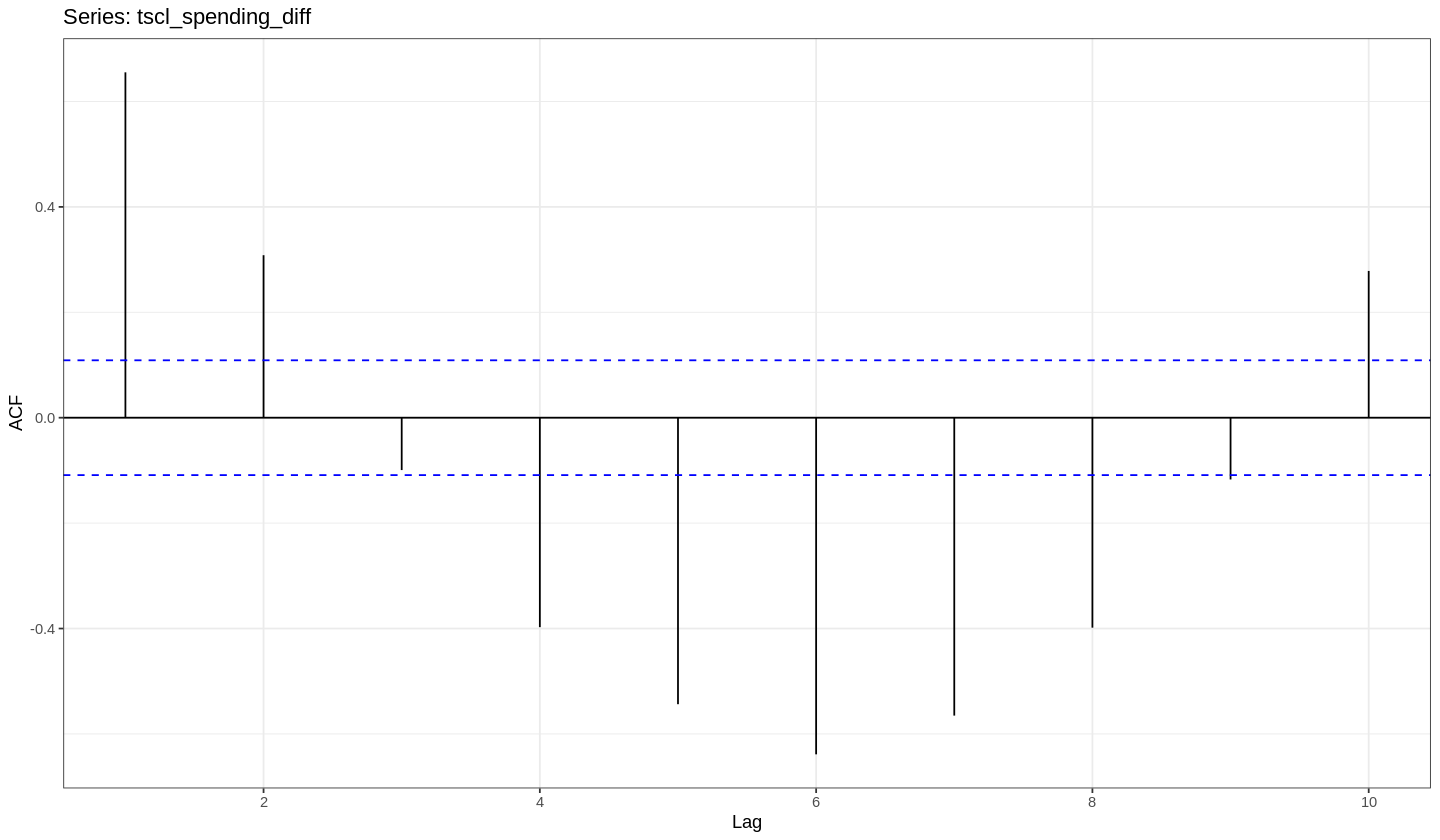

In [37]:
# PLOT tscl_spending_diff WITH ESTIMATES OF THE AUTOCORRELATION FUNCTION
ggAcf(x = tscl_spending_diff, lag.max = 10) + theme_bw()

### Partial Autocorrelation and Cross-Correlation Function

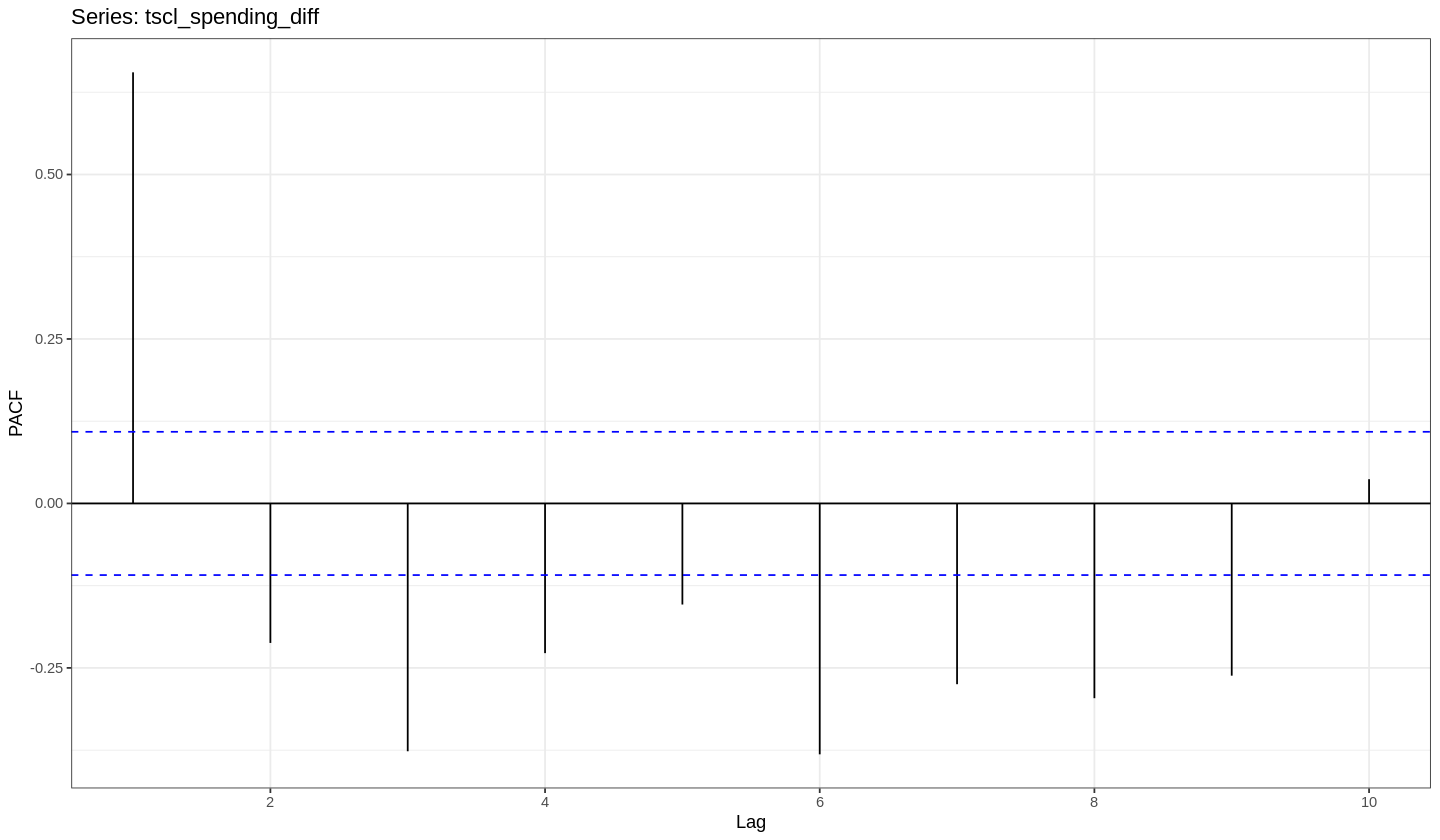

In [38]:
# PLOT tscl_spending_diff WITH ESTIMATES OF THE PARTIAL CORRELATION FUNCTION
ggPacf(x = tscl_spending_diff, lag.max = 10) + theme_bw()

## Fitting the ARIMA Model to SPY Monthly Closing Difference Data

In [39]:
# FIT AN ARIMA MODEL TO tscl_spending_diff
tscl_model_01 = Arima(tscl_spending_diff, order = c(1, 0, 1))
summary(tscl_model_01)

Series: tscl_spending_diff 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1     ma1      mean
      0.5732  0.1552  187.5123
s.e.  0.0586  0.0600  550.2736

sigma^2 estimated as 13637833:  log likelihood=-3119.92
AIC=6247.84   AICc=6247.96   BIC=6262.96

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE     MASE       ACF1
Training set 3.937112 3675.807 2896.582 202.4274 449.6009 2.679372 0.03178442


In [40]:
# FIT AN ARIMA MODEL TO tscl_spending_diff
tscl_model_02 = Arima(tscl_spending_diff, order = c(1, 0, 2))
summary(tscl_model_02)

Series: tscl_spending_diff 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1     ma1     ma2      mean
      0.3158  0.4012  0.4546  191.6581
s.e.  0.0886  0.0737  0.0861  526.5053

sigma^2 estimated as 12448011:  log likelihood=-3104.81
AIC=6219.62   AICc=6219.81   BIC=6238.53

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE     MASE      ACF1
Training set 4.456447 3506.327 2793.896 177.6048 451.1291 2.584386 0.0229447


In [41]:
# FIT AN ARIMA MODEL TO tscl_spending_diff
tscl_model_03 = Arima(tscl_spending_diff, order = c(2, 0, 1))
summary(tscl_model_01)

Series: tscl_spending_diff 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1     ma1      mean
      0.5732  0.1552  187.5123
s.e.  0.0586  0.0600  550.2736

sigma^2 estimated as 13637833:  log likelihood=-3119.92
AIC=6247.84   AICc=6247.96   BIC=6262.96

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE     MASE       ACF1
Training set 3.937112 3675.807 2896.582 202.4274 449.6009 2.679372 0.03178442


In [42]:
# FIT AN ARIMA MODEL TO tscl_spending_diff
tscl_model_04 = Arima(tscl_spending_diff, order = c(2, 0, 2))
summary(tscl_model_04)

Series: tscl_spending_diff 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
         ar1      ar2     ma1     ma2      mean
      0.2112  -0.3245  0.4700  0.8990  214.0907
s.e.  0.0612   0.0631  0.0254  0.0447  405.5132

sigma^2 estimated as 11993065:  log likelihood=-3099.3
AIC=6210.6   AICc=6210.86   BIC=6233.28

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE     MASE      ACF1
Training set 3.633719 3436.275 2684.557 147.5149 302.7491 2.483247 0.0730276


## ARIMA Forecasting Plot and Auto ARIMA Function

In [43]:
# DAILY CLOSING PRICE FOR 10 YEARS
tcs_10yrs = tcs_xts["2010-01-01/2020-01-04"][,'TTLCON']

# ASSIGN THE FIRST MONTH IN tcs_10yrs TO tcs_start
tcs_start = index(tcs_10yrs[1])
tcs_start = c(year(tcs_start),month(tcs_start))
# ASSIGN THE LAST MONTH IN tcs_10yrs TO tcs_end
tcs_end = index(tcs_10yrs[length(tcs_10yrs)])
tcs_end = c(year(tcs_end),month(tcs_end))

# CREATE A TIME-SERIES OBJECT AND ASSIGN TO tcs_10yrs_ts
tcs_10yrs_ts = ts(tcs_10yrs, start = tcs_start, end = tcs_end, frequency = 12)

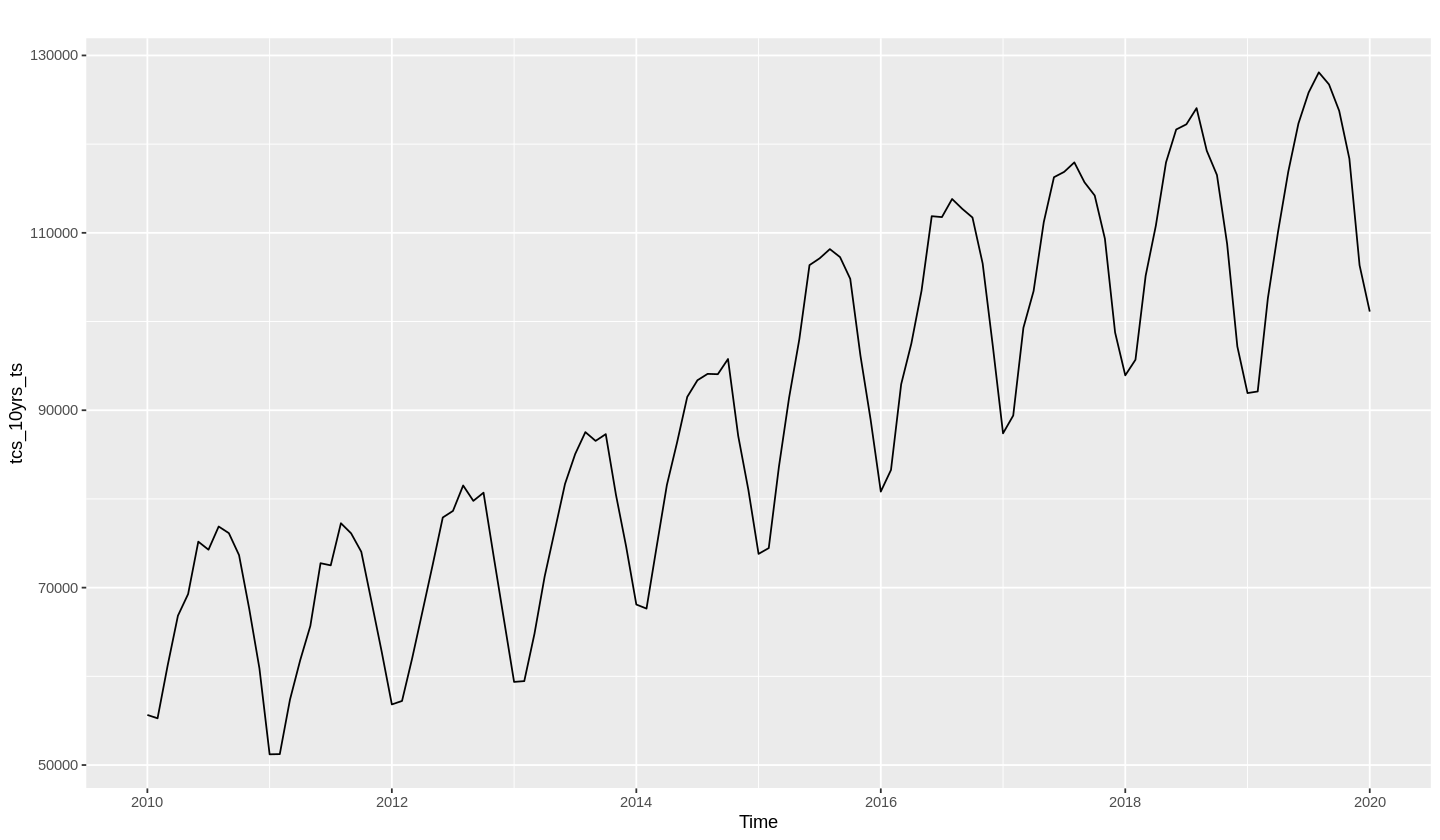

In [44]:
# PLOT tcs_10yrs_ts
autoplot(tcs_10yrs_ts)

In [45]:
# FIT BEST ARIMA MODEL TO tcs_10yrs_ts
tcs_model = auto.arima(tcs_10yrs_ts)

In [46]:
# PERFORM AUTOMATIC TIME SERIES FORECASTING
tcs_predict = forecast(tcs_model, h = 12)

In [47]:
# SUMMARY OF THE FORECASTING RESULTS
summary(tcs_predict)


Forecast method: ARIMA(0,1,0)(1,1,1)[12]

Model Information:
Series: tcs_10yrs_ts 
ARIMA(0,1,0)(1,1,1)[12] 

Coefficients:
        sar1     sma1
      0.5492  -0.7898
s.e.  0.2282   0.2074

sigma^2 estimated as 2270598:  log likelihood=-943.72
AIC=1893.44   AICc=1893.67   BIC=1901.49

Error measures:
                   ME     RMSE     MAE       MPE     MAPE      MASE        ACF1
Training set 154.3998 1410.361 1048.65 0.2077307 1.161974 0.1797873 -0.01787446

Forecasts:
         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Feb 2020       101516.0  99583.95 103448.0  98561.19 104470.8
Mar 2020       111482.5 108750.19 114214.8 107303.78 115661.2
Apr 2020       118523.4 115177.00 121869.8 113405.53 123641.3
May 2020       125071.9 121207.83 128936.0 119162.31 130981.5
Jun 2020       130603.3 126283.15 134923.5 123996.18 137210.5
Jul 2020       133413.8 128681.25 138146.3 126176.00 140651.5
Aug 2020       135591.3 130479.55 140703.0 127773.57 143408.9
Sep 2020       134085.1 12862

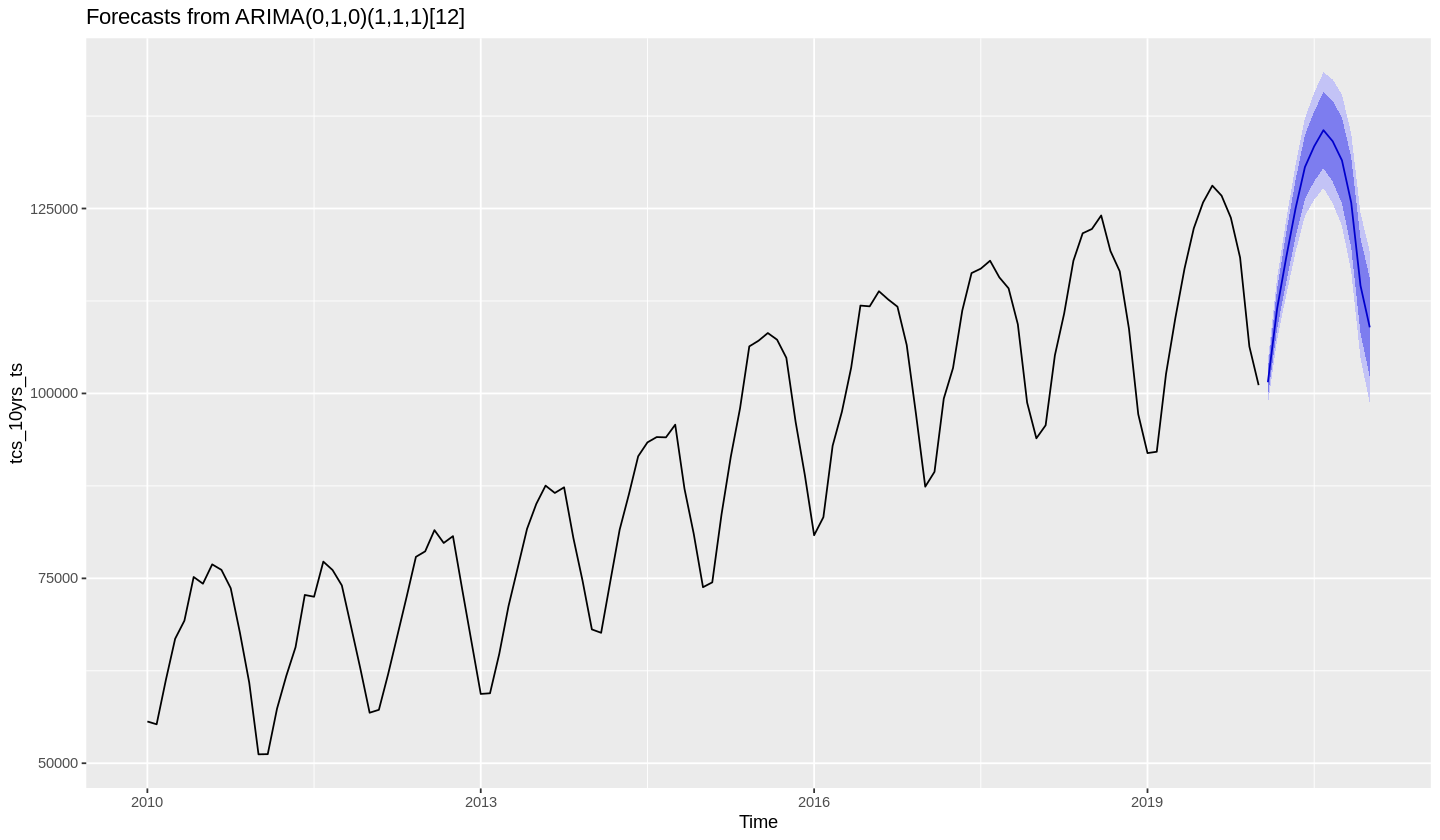

In [48]:
# PLOT THE FORECASTING RESULTS
autoplot(tcs_predict, includes = 50)

## Summary

On this lab we learned how to use analytical methods to analyze time series data and build forecasting models. We analyzed financial data in different forms and learned how to identify if a time series is stationary or not and how to transform nonstationary data to stationary to perform analysis. Some of the topics covered on this lab include testing for stationary, autocorrelation and cross-correlation function, and ARIMA forecasting model.

<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>